## Main function

In [65]:
def WALiMe(rootDir, metrics):
    
    ## Get a list of ORNs in the folder
    ornList = os.listdir(rootDir)
    
    for ORN in ornList:
        ## read the data in a df
        print '%s is in progress...' %(ORN)
        
        rootDir = os.path.join(rootDir,ORN)
        df = dataToDataframe(rootDir,metrics)
        
        ## apply the metrics
        TSALE(df,rootDir,dropNans=False,combineControls=True)
        
#         LaXS()       
        
        
    
    return df, summaryTable

## Crawl in the directory, load data in

In [66]:
## The InLight col we have in the count csv files and count tab in the tdms file is based on cX data. Meaning that we're doing
## head tracking but not using in the PI calculation.
## Here, I wrote a function to generate InLight column for a given HeadX coordinates and respective borders.
## I send only the headX while light ON (pattern01 or pattern10) to this function and return a binary list.
def InLightDetection(data,minimumBorder,maximumBorder):
    InLightBasedOnHeadXcoords = []
    
    for i in range(len(data)):
        if minimumBorder <= data[i] <= maximumBorder:
            InLightBasedOnHeadXcoords.append(1)
            
        else:
            InLightBasedOnHeadXcoords.append(0)
    return InLightBasedOnHeadXcoords

## Since the FPS from different cameras can be different, here I detect the FPS automatically rather than relying on user input.
def detectFPS(timeStamps):
    Second_prev = 0
    counter = 0 
    fpsDict= {}

    for i in range(len(timeStamps)):
        Second_next = timeStamps[i].second

        if Second_next == Second_prev:
            counter += 1 

        else:
            fpsDict[Second_prev] = counter
            counter = 0

        Second_prev = Second_next

    fps = Counter(fpsDict.values()).most_common()[0][0]
    
    return fps

def dataToDataframe(rootDir,metrics):
        
    ## Generate a single dataframe from the .tdms and pattern files 
    temp = {'Tdms file name':[],'Date':[],'Time':[],'mmPerPix':[],'fps':[],'Light type':[],'Light Intensity(uW/mm2)':[],'Wind status':[],
            'Satiety':[],'Genotype':[],'Sex':[],'Status':[],'Fly ID':[],'cX(pix)':[],'HeadX(pix)':[],'HeadX(pix)_smoothed':[],
            'HeadY(pix)':[], 'InLight':[],'InLight_HeadX|P01':[],'InLight_HeadX|P10':[],'First light contact index_of_the_whole_data|P01':[],'First light contact index_of_the_whole_data|P10':[],
            'LightON index|P01':[],'First light contact index in P01':[],'First light contact index in P10':[],'LightON index|P10':[],'Border|P01':[],'Border|P10':[]}
    
    slidingWindowSizeinframes = 25
    numOfTdmsFiles = 0
    ## get access to the files in each ORN folder
    fileList = os.listdir(rootDir)
    bar = progressbar.ProgressBar()       
    ## Loop thru the file list to find tdms files and their related csv pattern files
    for fname in bar(fileList):
        if fname[-5:] == '.tdms':    
            numOfTdmsFiles += 1
            ## Open the tdms file
            f = TdmsFile(os.path.join(rootDir,fname))

            ## Load the tdms into a pandas df
            TDMSdf = f.as_dataframe()

            try:
            ## Open the pattern csv files to extract light border info per fly
                tdmsNameNoExtension = fname[:-5]
                P01_fname = tdmsNameNoExtension + '_Pattern01.csv'
                P10_fname = tdmsNameNoExtension + '_Pattern10.csv'
                
                P01_df = pd.read_csv(os.path.join(rootDir,P01_fname))
                P10_df = pd.read_csv(os.path.join(rootDir,P10_fname))
                
            except:
                print 'No pattern file(s) for %s' %(tdmsNameNoExtension)
                

            ## Get exp info from the tdms filename
            tdmsNameNoExtension = tdmsNameNoExtension.split('_')
            date = tdmsNameNoExtension[1]
            time = tdmsNameNoExtension[2]
            genotype = tdmsNameNoExtension[3]
            sex = tdmsNameNoExtension[4]
            intensity = tdmsNameNoExtension[5] + '_' + tdmsNameNoExtension[6]
            lightType = 'Constant'
            windState = tdmsNameNoExtension[7]
            satiety = tdmsNameNoExtension[8]

            ## Get the mm per pixel coefficient
            metaData = f.object().properties
            mmPerPix = metaData['X_mm_per_pixel']

            ## Detect the fps of the data for the LXS metric

            timeStamps = pd.to_datetime(TDMSdf["/\'Count\'/\'Time'"])
            fps = detectFPS(timeStamps)

            ## Get status info 
            if ('w1118' in genotype) | ('W1118' in genotype):
                status = 'Parent'
            elif (('Gal4' in genotype) | ('GAL4' in genotype)) & ('UAS' in genotype):
                status = 'Offspring'
            else:
                status = 'Unknown'
                print 'Unknown parental status in file %s' % (fname)

            ## simply putting fly IDs as numbers does not work due to missing chambers (i.e 3,4,6,7)
            ## thus, get a list of column names with fly IDs
            listOfFlyIDs = TDMSdf.columns[TDMSdf.columns.str.contains("/'Tracker'/'HeadX_pix")]

            for fly in listOfFlyIDs:

                ## get the fly ID from the data itself
                flyIndex = int(fly[-4:-1])

                ## format the fly index into 3 digits number,i.e '5' >> '005' 
                flyID = format(str(flyIndex).zfill(3))

                ## generate column names for the data need to be pulled from the df
                fly_cX_pix_ID = "/\'Count\'/\'Obj%s_cX'" % flyIndex 
                fly_inLight_ID = "/\'Count\'/\'Obj%s_InLight'" % flyIndex
                fly_headX_pix_ID = "/'Tracker'/'HeadX_pix" + str(flyID) + "'"
                fly_headY_pix_ID = "/'Tracker'/'HeadY_pix" + str(flyID) + "'"

                temp['Fly ID'].append(flyID)
                temp['cX(pix)'].append(TDMSdf[fly_cX_pix_ID].values.astype(float))
                temp['InLight'].append(TDMSdf[fly_inLight_ID].values.astype(float))
                temp['HeadX(pix)'].append(TDMSdf[fly_headX_pix_ID].values.astype(float))
                temp['HeadX(pix)_smoothed'].append(pd.rolling_mean(TDMSdf[fly_headX_pix_ID].values.astype(float),
                                                   window = slidingWindowSizeinframes, center=True, win_type="triang"))
                temp['HeadY(pix)'].append(TDMSdf[fly_headY_pix_ID].values.astype(float))

            ## Get the chunks where the light was ON   
            TDMSdf_pat01 = TDMSdf[TDMSdf["/\'Count\'/\'PatternState'"] == 'Pattern 01']    
            TDMSdf_pat10 = TDMSdf[TDMSdf["/\'Count\'/\'PatternState'"] == 'Pattern 10'] 

            LightOnP01 = min(TDMSdf_pat01.index),max(TDMSdf_pat01.index)
            LightOnP10 = min(TDMSdf_pat10.index),max(TDMSdf_pat10.index)

            for fly in listOfFlyIDs:
                ## get the fly ID from the data itself
                flyIndex = int(fly[-4:-1])

                ## format the fly index into 3 digits number,i.e '5' >> '005' 
                flyID = format(str(flyIndex).zfill(3))

                ## generate column names for the data need to be pulled from the df
                fly_headX_pix_ID = "/'Tracker'/'HeadX_pix" + str(flyID) + "'"
                border_P01 = P01_df.filter(regex='pix').iloc[1].values[flyIndex-1]
                border_P10 = P10_df.filter(regex='pix').iloc[1].values[flyIndex-1]

                ## get the headX coordinates of the fly where the light was ON - pattern01 or pattern10
                headXcoord_P01 = TDMSdf_pat01[fly_headX_pix_ID].values.astype(float)
                headXcoord_P10 = TDMSdf_pat10[fly_headX_pix_ID].values.astype(float)  

                ## send this data to the function along with the respective border info to get a binary list,
                ## indicating whether the fly was in the light or not.
                InLightBasedOnHeadX_P01 = InLightDetection(headXcoord_P01,border_P01,146)
                InLightBasedOnHeadX_P10 = InLightDetection(headXcoord_P10,0,border_P10)

                ## if the fly had ever been in the light, get the first time she did.
                if 1 in InLightBasedOnHeadX_P01:
                    P01_first_light_contact_index_of_the_whole_data = int(LightOnP01[0]) + int(InLightBasedOnHeadX_P01.index(1))
                    P01_first_light_contact_index_in_the_event = int(InLightBasedOnHeadX_P01.index(1))
                else:
                    P01_first_light_contact_index_of_the_whole_data = None
                    P01_first_light_contact_index_in_the_event = None

                if 1 in InLightBasedOnHeadX_P10:
                    P10_first_light_contact_index_of_the_whole_data = int(LightOnP10[0]) + int(InLightBasedOnHeadX_P10.index(1))
                    P10_first_light_contact_index_in_the_event = int(InLightBasedOnHeadX_P10.index(1))
                else:
                    P10_first_light_contact_index_of_the_whole_data = None
                    P10_first_light_contact_index_in_the_event = None

                ## append the info to temp dict
                temp['First light contact index_of_the_whole_data|P01'].append(P01_first_light_contact_index_of_the_whole_data)
                temp['First light contact index_of_the_whole_data|P10'].append(P10_first_light_contact_index_of_the_whole_data)  
                temp['First light contact index in P01'].append(P01_first_light_contact_index_in_the_event)
                temp['First light contact index in P10'].append(P10_first_light_contact_index_in_the_event)
                temp['Tdms file name'].append(fname)
                temp['Date'].append(date)
                temp['Time'].append(time)
                temp['mmPerPix'].append(mmPerPix)
                temp['fps'].append(fps)
                temp['Light type'].append(lightType)
                temp['Light Intensity(uW/mm2)'].append(intensity)
                temp['Wind status'].append(windState)
                temp['Satiety'].append(satiety)
                temp['Genotype'].append(genotype)
                temp['Sex'].append(sex)
                temp['Status'].append(status)
                temp['LightON index|P01'].append(LightOnP01)
                temp['LightON index|P10'].append(LightOnP10)
                temp['Border|P01'].append(border_P01)
                temp['Border|P10'].append(border_P10)
                temp['InLight_HeadX|P01'].append(InLightBasedOnHeadX_P01)
                temp['InLight_HeadX|P10'].append(InLightBasedOnHeadX_P10)

    ## Convert temp into a df
    colOrder = ['Tdms file name','Date','Time','mmPerPix','fps','Light type','Light Intensity(uW/mm2)','Wind status',
                'Satiety','Genotype','Sex','Status','Fly ID','cX(pix)','HeadX(pix)','HeadX(pix)_smoothed','HeadY(pix)',
                'InLight','InLight_HeadX|P01','InLight_HeadX|P10','First light contact index_of_the_whole_data|P01','First light contact index_of_the_whole_data|P10',
                'LightON index|P01','First light contact index in P01','First light contact index in P10','LightON index|P10','Border|P01','Border|P10']

    results = pd.DataFrame(temp,columns=colOrder)
    results.to_pickle(rootDir + '/RawDataFrame.pkl')
    ## summary of the raw data
    summaryTable = results.groupby(['Genotype','Sex','Satiety','Wind status','Light Intensity(uW/mm2)']).size().reset_index(name='counts')
    summaryTable.to_csv(rootDir + '/SummaryTableofTheRawData.csv')
    return results

## Metric: LaXS

In [142]:
## Usual PI calculation, called by
def calculatePI(data):
    
    numofTimePoints = len(data)
    totalTimeinLight = sum(data)
    totalTimeinDark = numofTimePoints - totalTimeinLight
    
    PI = float(totalTimeinLight - totalTimeinDark)/float(numofTimePoints)
    return PI

def LaXS(df, rootDir, Xsec = 30, combineControls=False):
    numberOfFlies = df.shape[0]
    LXS_P01_list = []
    LXS_P10_list = []
    
    ## calculate LXS PI for each fly/row, and epoch (P01 | P10)
    for fly in range(0,numberOfFlies):
        
        ## detect how many frames need to take from the tail
        numberOfFrames = Xsec * int(df['fps'][fly])
        
        ## get the "in light or not" list per epoch
        inLight_headX_P01 = df['InLight_HeadX|P01'][fly][-numberOfFrames:]
        inLight_headX_P10 = df['InLight_HeadX|P10'][fly][-numberOfFrames:]
        
        ## send them to the calculate PI function
        LXS_P01 = calculatePI(inLight_headX_P01)
        LXS_P10 = calculatePI(inLight_headX_P10)
        
        ## store the PIs in lists
        LXS_P01_list.append(LXS_P01)
        LXS_P10_list.append(LXS_P10)
    
    ## add the new lists of information to the existing df
    df = df.assign(LaXS_P01 = pd.Series(LXS_P01_list, index=df.index),
                   LaXS_P10 = pd.Series(LXS_P10_list, index=df.index))
    
    df = df.assign(LaXS_Mean = pd.Series(df[['LaXS_P01','LaXS_P10']].mean(axis=1), 
                                                    index=df.index))
    
    plotTheMetric(df,'LaXS',rootDir,combineControls)
    
    return None

## Metric: TSALE

In [117]:
def TSALE(df, rootDir, combineControls=False, dropNans=False):
    numberOfFlies = df.shape[0]
    PI_afterLightContact_P01 = []
    PI_afterLightContact_P10 = []
    
    ## iterate thru the flies to calculate PI scores
    ## PI scores are calculated seperately for first and second halves of the experiment
    for fly in range(0,numberOfFlies):
        
        ## get the first light contact index for the fly
        firstLightContactIndex_P01 = df['First light contact index in P01'][fly]
        firstLightContactIndex_P10 = df['First light contact index in P10'][fly]
        
        ## if the light contact index is NOT nan, calculate the PI and attach it to the list
        ## otherwise attach a np.nan value
        if not np.isnan(firstLightContactIndex_P01):
            
            ## select the data after fly was exposed to the light
            InLightDatainTheRange_P01 = df['InLight_HeadX|P01'][fly][int(firstLightContactIndex_P01):]
            ## calculate PI score
            numOfDataPoints_P01 = len(InLightDatainTheRange_P01)
            numOfInLights_P01 = sum(InLightDatainTheRange_P01)
            numOfInDarks_P01 = numOfDataPoints_P01 - numOfInLights_P01
           
            PI_P01 = float(numOfInLights_P01 - numOfInDarks_P01)/float(numOfDataPoints_P01)
            PI_afterLightContact_P01.append(PI_P01)
        
        elif np.isnan(firstLightContactIndex_P01):
            PI_afterLightContact_P01.append(np.nan)
        
        else:
            None
        
        ## same as the first half of the exp: P01
        if not np.isnan(firstLightContactIndex_P10):
            
            InLightDatainTheRange_P10 = df['InLight_HeadX|P10'][fly][int(firstLightContactIndex_P10):]
            numOfDataPoints_P10 = len(InLightDatainTheRange_P10)
            numOfInLights_P10 = sum(InLightDatainTheRange_P10)
            numOfInDarks_P10 = numOfDataPoints_P10 - numOfInLights_P10
            
            PI_P10 = float(numOfInLights_P10 - numOfInDarks_P10)/float(numOfDataPoints_P10)
            PI_afterLightContact_P10.append(PI_P10)
        
        elif np.isnan(firstLightContactIndex_P10):
            PI_afterLightContact_P10.append(np.nan)
        
        else:
            None
        
        ## add the Preference Index pattern01 and pattern10 to the df
    df = df.assign(TSALE_P01 = pd.Series(PI_afterLightContact_P01, index=df.index),
                   TSALE_P10 = pd.Series(PI_afterLightContact_P10, index=df.index))
    
    df = df.assign(TSALE_Mean = pd.Series(df[['TSALE_P01','TSALE_P10']].mean(axis=1), index=df.index))
    
    droppedNans = MeanPreferenceIndexNoNANs(df)
    
    if dropNans == True:
        plotTheMetric(droppedNans,'TSALE',rootDir,combineControls,dropNans)
        
        return droppedNans
    else:
        plotTheMetric(df,'TSALE',rootDir,combineControls,dropNans)
    
        return df

## Nans in the PreferenceIndex_P01 (and P10) columns are treated as not existing in the plotting;
## therefore, when I am getting the mean of the two columns, I can't treat them as zeroes. 
## This function, first removes all the rows where either PreferenceIndex_P01 OR PreferenceIndex_P10 is Nan,
## then calculates a PreferenceIndex_Mean column to the df.
def MeanPreferenceIndexNoNANs(df):
    
    droppedNans = df.dropna(subset = ['TSALE_P10','TSALE_P01'])
    droppedNans = droppedNans.assign(TSALE_Mean_noNan = pd.Series(droppedNans[['TSALE_P01','TSALE_P10']].mean(axis=1), index = droppedNans.index))
    droppedNans = droppedNans.reset_index(drop=True)
    
    return droppedNans

## Metric: weighted-TSALE

In [118]:
def weighted_TSALE(dff, rootDir, combineControls=False, dropNans=False):
    
    df = TSALE(dff, rootDir, dropNans, combineControls)
    ## empty lists to store the weights for both epochs
    weights_P01 = []
    weights_P10 = []
    numofflies = df.shape[0]
    
    ## calculate weights per fly
    for i in range(numofflies):
        numofFrames_P01 = len(df['InLight_HeadX|P01'][i])
        firstContact_P01 = df['First light contact index in P01'][i]

        if not np.isnan(firstContact_P01):
            ## weight is calculated as: remaining time after the discovery / whole epoch
            w_P01 = (numofFrames_P01-firstContact_P01)/float(numofFrames_P01)
            weights_P01.append(w_P01)
        else:
            weights_P01.append(np.nan) 

        numofFrames_P10 = len(df['InLight_HeadX|P10'][i])
        firstContact_P10 = df['First light contact index in P10'][i]

        if not np.isnan(firstContact_P10):
            ## weight is remaining time after the discovery / whole epoch
            w_P10 = (numofFrames_P10-firstContact_P10)/float(numofFrames_P10)
            weights_P10.append(w_P10)
        else:
            weights_P10.append(np.nan) 

    df = df.assign(weights_P01 = pd.Series(weights_P01, index=df.index),
                   weights_P10 = pd.Series(weights_P10, index=df.index))

    df = df.assign(weighted_TSALE_P01 = pd.Series(df['weights_P01'] * df['TSALE_P01'], index=df.index),
                   weighted_TSALE_P10 = pd.Series(df['weights_P10'] * df['TSALE_P10'], index=df.index))

    df = df.assign(weighted_TSALE_Mean = pd.Series(df[['weighted_TSALE_P01','weighted_TSALE_P10']].mean(axis=1), index=df.index))
    
    plotTheMetric(df,'weighted_TSALE',rootDir,combineControls,dropNans)
    
    return None

## Metric: Light attraction index

In [168]:
## Function 1: Detect choice zone entrance/exits indices, store them in the df
## Pass the df to these functions:
    ## Function 2: Sort and Plot the tracts as in Wilson paper _ this only needs the entrance indices
    ## Function 2.5: To plot the mean trajactories as in the Wilson paper, need an alignment function. Choice zone borders vary.
    ## Function 3: Calculate Attraction Index from the exits _ this needs the exit indice, as well as coordination to decide 
    ## whether traversel or reversal.

    ###!!! Fix HeadX to smoothed headX
def DetectEntraceandExitIndicesToTheChoiceZone(df, choiceZoneWidth_mm = 10, thresholdToExcludeCursorJumps_pix = 20):

    ## Lists to store the entrance and corresponding exits info per fly for P01 and P10
    FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []

    FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = []
    
    ## Lists to stores choice zone borders per fly
    ChoiceZoneBordersPerFly_P01 = []
    ChoiceZoneBordersPerFly_P10 = []
    
    numberOfFlies = df.shape[0]

    ## get the mm to pix coefficient
    mmPerPix = df['mmPerPix'][0]

    ## convert the zone width from mm to pix
    choiceZoneWidth_pix = choiceZoneWidth_mm/mmPerPix

    for fly in range(0,numberOfFlies):

        ## one fly can have multiple decisions; I will keep seperate lists per fly
        flyDecisionList_theWindPortEnd_P01 = []
        flyDecisionList_theClosedEnd_P01 = []

        flyDecisionList_theWindPortEnd_P10 = []
        flyDecisionList_theClosedEnd_P10 = []

        ## get border coordinates for the two light events per fly
        border_P01 = df.iloc[fly]['Border|P01']
        border_P10 = df.iloc[fly]['Border|P10'] 

        ## identify the choice zone lef-right borders per chamber, since borders change across chambers, even P01 vs P10 
        choiceZoneBorders_P01 = [border_P01-choiceZoneWidth_pix/2, border_P01+choiceZoneWidth_pix/2]
        choiceZoneBorders_P10 = [border_P10-choiceZoneWidth_pix/2, border_P10+choiceZoneWidth_pix/2]
        
        ## store the border info to be attached to the df
        ChoiceZoneBordersPerFly_P01.append(choiceZoneBorders_P01)
        ChoiceZoneBordersPerFly_P10.append(choiceZoneBorders_P10)
        ## NTS: In Adam's paper, only when flies enter and exit counted as a decision.

        ## get the indices where P01 and P10 were taking place      
        P01_startIndex, P01_endIndex = df.iloc[fly]['LightON index|P01']
        P10_startIndex, P10_endIndex = df.iloc[fly]['LightON index|P10']

        ## get head X coordinates while the light was ON, P01 and P10
        headXcoordIn_P01 = df.iloc[fly]['HeadX(pix)'][P01_startIndex:P01_endIndex]
        headXcoordIn_P10 = df.iloc[fly]['HeadX(pix)'][P10_startIndex:P10_endIndex]

        ## go thru the head X coordinates during the P01 event to find entrances and related exits(if any)
        for i in range(len(headXcoordIn_P01)-1): 
            
            ## if entering to the zone from the wind port end
            if (headXcoordIn_P01[i] < choiceZoneBorders_P01[0]) & ((headXcoordIn_P01[i+1] > choiceZoneBorders_P01[0]) & (headXcoordIn_P01[i+1] < choiceZoneBorders_P01[1])):
               
                ## store the entrance info [entrance index, entrance coor]
                temp = [P01_startIndex+i+1, headXcoordIn_P01[i+1]]

                ## now detect the exit of this entrance
                for j in range(len(headXcoordIn_P01[i:])-1):

                    if (headXcoordIn_P01[i:][j+1] < choiceZoneBorders_P01[0]) | (headXcoordIn_P01[i:][j+1] > choiceZoneBorders_P01[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P01_startIndex+i+j+1)
                        temp.append(headXcoordIn_P01[i+j+1])
                        break

                flyDecisionList_theWindPortEnd_P01.append(temp)
                
            ## found an entrance from the closed end of the chamber
            if (headXcoordIn_P01[i] > choiceZoneBorders_P01[1]) & ((headXcoordIn_P01[i+1] < choiceZoneBorders_P01[1]) & (headXcoordIn_P01[i+1] > choiceZoneBorders_P01[0])):

                ## store the entrance info [entrance index, entrance coor]
                temp = [P01_startIndex+i+1, headXcoordIn_P01[i+1]]

                ## now detect the exit of this entrance, if any
                for j in range(len(headXcoordIn_P01[i:])-1):

                    if (headXcoordIn_P01[i:][j+1] < choiceZoneBorders_P01[0]) | (headXcoordIn_P01[i:][j+1] > choiceZoneBorders_P01[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P01_startIndex+i+j+1)
                        temp.append(headXcoordIn_P01[i+j+1])
                        break
                        
                ## add this decision to the list before searching for other decisions of the same fly 
                flyDecisionList_theClosedEnd_P01.append(temp)
        
        
        ## go thru the head X coordinates during the P10 event to find entrances and related exits(if any)
        for i in range(len(headXcoordIn_P10)-1): 
            
            ## if entering to the zone from the wind port end
            if (headXcoordIn_P10[i] < choiceZoneBorders_P10[0]) & ((headXcoordIn_P10[i+1] > choiceZoneBorders_P10[0]) & (headXcoordIn_P10[i+1] < choiceZoneBorders_P10[1])):
                
                ## store the entrance info [entrance index, entrance coor]
                temp = [P10_startIndex+i+1, headXcoordIn_P10[i+1]]
                
                ## now detect the exit of this entrance
                for j in range(len(headXcoordIn_P10[i:])-1):

                    if (headXcoordIn_P10[i:][j+1] < choiceZoneBorders_P10[0]) | (headXcoordIn_P10[i:][j+1] > choiceZoneBorders_P10[1]):

                        ## attach the exit to the temp list [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P10_startIndex+i+j+1)
                        temp.append(headXcoordIn_P10[i+j+1])
                        break

                flyDecisionList_theWindPortEnd_P10.append(temp)
                
            ## found an entrance from the closed end of the chamber
            if (headXcoordIn_P10[i] > choiceZoneBorders_P10[1]) & ((headXcoordIn_P10[i+1] < choiceZoneBorders_P10[1]) & (headXcoordIn_P10[i+1] > choiceZoneBorders_P10[0])):

                ## store the entrance info [entrance index, entrance coor]
                temp = [P10_startIndex+i+1, headXcoordIn_P10[i+1]]

                ## now detect the exit of this entrance, if any
                for j in range(len(headXcoordIn_P10[i:])-1):

                    if (headXcoordIn_P10[i:][j+1] < choiceZoneBorders_P10[0]) | (headXcoordIn_P10[i:][j+1] > choiceZoneBorders_P10[1]):

                        ## attach the exit to the temp lis, [entrance index, entrance coor, exit index, exit coor]
                        temp.append(P10_startIndex+i+j+1)
                        temp.append(headXcoordIn_P10[i+j+1])
                        break
                        
                ## add this decision to the list before searching for other decisions of the same fly 
                flyDecisionList_theClosedEnd_P10.append(temp)

        FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theWindPortEnd_P01)
        FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theClosedEnd_P01)

        FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theWindPortEnd_P10)
        FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX.append(flyDecisionList_theClosedEnd_P10)
    
    df = df.assign(ChoiceZoneBordersperFly_P01 = pd.Series(ChoiceZoneBordersPerFly_P01, index=df.index),
                   ChoiceZoneBordersperFly_P10 = pd.Series(ChoiceZoneBordersPerFly_P10, index=df.index),
                   FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index),
                   FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX = pd.Series(FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX, index=df.index))
    return df

def LAI(df, rootDir, combineControls=False, dropNans=False):
 
    ## Caution: when you are calculating the LAI_Mean, getting the avarage of P01 and P10 may yield different results than
    ## counting the votes for the two epochs.
    ## P01 most probably will be excluded due to the conflicting of interpretations when the wind applied.
    ## So, don't worry too much about the mean LAI.
    ## LAI does not need to be calculated seperately for down and upwind cases. Combine them together.
    ## The downwind/upwind will be nice to see in the path-analysis, and number of border crossings.
    df = DetectEntraceandExitIndicesToTheChoiceZone(df)
    
    LightAttractionIndex_P01 = []
    LightAttractionIndex_P10 = []

    # go through all the flies
    for fly in range(len(df)):

        entrance_exit_log_P01 = []
        entrance_exit_log_P10 = []

        number_of_light_votes_P01 = 0
        number_of_dark_votes_P01 = 0

        number_of_light_votes_P10 = 0
        number_of_dark_votes_P10 = 0
        ## combine the choice events for P01 and P10, regardless to which part of the chamber flies entered to the zone
        entrance_exit_log_P01.extend(df['FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P01.extend(df['FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        entrance_exit_log_P10.extend(df['FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P10.extend(df['FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        ## get the choice zone borders per fly to detect whether exit was to light or dark side
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]
        ## go thru the entrances per fly and find out where the exits were made to
        ## note that the light and dark sides are different sides of the border in each epoch
        ## for P01
        if entrance_exit_log_P01:
            for log in entrance_exit_log_P01:
                if len(log) == 4:
                    exit_headX = log[3]
                    
                    ## NTS: using border line, instead of the choice zone borders, to compare the exit headX. Otherwise it
                    ## fucks up.
                    ##exit to the light side
                    if exit_headX > border_P01:
                        number_of_light_votes_P01 = number_of_light_votes_P01 + 1

                    ##exit to the dark side    
                    elif exit_headX < border_P01:
                        number_of_dark_votes_P01 =  number_of_dark_votes_P01 + 1
            
            if (number_of_light_votes_P01 + number_of_dark_votes_P01) != 0:
                LAI_P01 = (float(number_of_light_votes_P01) - float(number_of_dark_votes_P01))/(float(number_of_light_votes_P01) + float(number_of_dark_votes_P01))
                LightAttractionIndex_P01.append(LAI_P01)
            else:
                LightAttractionIndex_P01.append(np.nan)
        else:
            LightAttractionIndex_P01.append(np.nan)
            
        ## for P10
        if entrance_exit_log_P10:
            for log in entrance_exit_log_P10:
                if len(log) == 4:
                    exit_headX = log[3]

                    ##exit to the dark side
                    if exit_headX > border_P10:
                        number_of_dark_votes_P10 =  number_of_dark_votes_P10 + 1

                    ##exit to the light side    
                    elif exit_headX < border_P10:
                        number_of_light_votes_P10 = number_of_light_votes_P10 + 1
            if (number_of_light_votes_P10 + number_of_dark_votes_P10) != 0:
                LAI_P10 = (float(number_of_light_votes_P10) - float(number_of_dark_votes_P10))/(float(number_of_light_votes_P10) + float(number_of_dark_votes_P10))
                LightAttractionIndex_P10.append(LAI_P10)
            else:
                LightAttractionIndex_P10.append(np.nan)
        else:
            LightAttractionIndex_P10.append(np.nan) 

    df = df.assign(LAI_P01 = pd.Series(LightAttractionIndex_P01, index=df.index),
                   LAI_P10 = pd.Series(LightAttractionIndex_P10, index=df.index))

    df = df.assign(LAI_Mean = pd.Series(df[['LAI_P01','LAI_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'LAI',rootDir,combineControls,dropNans)
    return df

## Metrix: Reversal PI

In [120]:
def RPI(df, rootDir, combineControls=False, dropNans=False):
 
    df = DetectEntraceandExitIndicesToTheChoiceZone(df)
    
    ReversalPI_P01 = []
    ReversalPI_P10 = []
    
    # go through all the flies
    for fly in range(len(df)):

        entrance_exit_log_P01 = []
        entrance_exit_log_P10 = []

        number_of_light_reversals_P01 = 0
        number_of_dark_reversals_P01 = 0

        number_of_light_reversals_P10 = 0
        number_of_dark_reversals_P10 = 0
        
        ## Use both the wind port and closed end entrances
        entrance_exit_log_P01.extend(df['FromTheClosedEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P01.extend(df['FromTheWindPortEnd_P01_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        entrance_exit_log_P10.extend(df['FromTheClosedEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])
        entrance_exit_log_P10.extend(df['FromTheWindPortEnd_P10_EnterIdx_EnterHeadX_ExitIdx_ExitHeadX'][fly])

        ## get the border lines per fly to detect whether exit was to light or dark side
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]
        
        ## go thru the entrances per fly and find out where the exits were made to
        ## note that the light and dark sides are different sides of the border in each epoch
        ## for P01
        if entrance_exit_log_P01:
            for log in entrance_exit_log_P01:
                if len(log) == 4:
                    enter_headX = log[1]
                    exit_headX = log[3]
                    
                    ##came from to the dark side, returned to the dark side
                    if (enter_headX < border_P01) & (exit_headX < border_P01):
                        number_of_dark_reversals_P01 = number_of_dark_reversals_P01 + 1

                    ##came from the lit side, returned to the lit side   
                    elif (enter_headX > border_P01) & (exit_headX > border_P01):
                        number_of_light_reversals_P01 =  number_of_light_reversals_P01 + 1
                        
            if (number_of_dark_reversals_P01 + number_of_light_reversals_P01) != 0:
                RPI_P01 = (float(number_of_light_reversals_P01) - float(number_of_dark_reversals_P01))/(float(number_of_light_reversals_P01) + float(number_of_dark_reversals_P01))
                ReversalPI_P01.append(RPI_P01)
                
            else:
                ReversalPI_P01.append(np.nan)
        else:
            ReversalPI_P01.append(np.nan)
            
        ## for P10
        if entrance_exit_log_P10:
            for log in entrance_exit_log_P10:
                if len(log) == 4:
                    enter_headX = log[1]
                    exit_headX = log[3]

                    ##came from light, returned to the lit side
                    if (enter_headX < border_P10) & (exit_headX < border_P10):
                        number_of_light_reversals_P10 =  number_of_light_reversals_P10 + 1

                    ##came from the dark half, returned to the dark half   
                    elif (enter_headX > border_P10) & (exit_headX > border_P10):
                        number_of_dark_reversals_P10 = number_of_dark_reversals_P10 + 1
                        
            if (number_of_dark_reversals_P10 + number_of_light_reversals_P10) != 0:
                RPI_P10 = (float(number_of_light_reversals_P10) - float(number_of_dark_reversals_P10))/(float(number_of_dark_reversals_P10) + float(number_of_light_reversals_P10))
                ReversalPI_P10.append(RPI_P10)
            else:
                ReversalPI_P10.append(np.nan)
        else:
            ReversalPI_P10.append(np.nan) 

    df = df.assign(RPI_P01 = pd.Series(ReversalPI_P01, index=df.index),
                   RPI_P10 = pd.Series(ReversalPI_P10, index=df.index))

    df = df.assign(RPI_Mean = pd.Series(df[['RPI_P01','RPI_P10']].mean(axis=1), index=df.index))
    
    plotTheMetric(df,'RPI',rootDir,combineControls,dropNans)
    return df

## Metric: Number of Border Crossings

In [167]:
### NTS: fix this to SMOOTHED HEAD X!!
def NoBC(df, rootDir, combineControls=False, dropNans=False):
    
    ## lists to keep the metric for each fly
    list_of_number_of_border_crossings_P01 = []
    list_of_number_of_border_crossings_P10 = []

    for fly in range(len(df)):

        ## get the P01 and P10 epoch indices
        start_of_P01 = df['LightON index|P01'][fly][0]
        end_of_P01 = df['LightON index|P01'][fly][1]

        start_of_P10 = df['LightON index|P10'][fly][0]
        end_of_P10 = df['LightON index|P10'][fly][1]

        ## get the head X positions during the epochs
        headX_during_P01 = df['HeadX(pix)'][fly][start_of_P01:end_of_P01]
        headX_during_P10 = df['HeadX(pix)'][fly][start_of_P10:end_of_P10]

        ## get the border corrdinates
        border_P01 = df['Border|P01'][fly]
        border_P10 = df['Border|P10'][fly]

        ## values to keep the crossings for each fly
        number_of_border_crossings_P01 = 0
        number_of_border_crossings_P10 = 0

        ## go thru the headX coords and detect border crossings
        ## for P01 epoch
        for i in range(len(headX_during_P01)-1):
            current_coor = headX_during_P01[i]
            next_coor = headX_during_P01[i+1]

            if (current_coor > border_P01) & (next_coor < border_P01):
                number_of_border_crossings_P01 = number_of_border_crossings_P01 + 1
            elif (current_coor < border_P01) & (next_coor > border_P01):
                number_of_border_crossings_P01 = number_of_border_crossings_P01 + 1
        list_of_number_of_border_crossings_P01.append(number_of_border_crossings_P01)

        ## go thru the headX coords and detect border crossings
        ## for P10 epoch
        for i in range(len(headX_during_P10)-1):
            current_coor = headX_during_P10[i]
            next_coor = headX_during_P10[i+1]

            if (current_coor > border_P10) & (next_coor < border_P10):
                number_of_border_crossings_P10 = number_of_border_crossings_P10 + 1
                
            elif (current_coor < border_P10) & (next_coor > border_P10):
                number_of_border_crossings_P10 = number_of_border_crossings_P10 + 1

        list_of_number_of_border_crossings_P10.append(number_of_border_crossings_P10)
    
    df = df.assign(NoBC_P01 = pd.Series(list_of_number_of_border_crossings_P01, index=df.index),
                   NoBC_P10 = pd.Series(list_of_number_of_border_crossings_P10, index=df.index))

    df = df.assign(NoBC_Mean = pd.Series(df[['NoBC_P01','NoBC_P10']].mean(axis=1), index=df.index))
    plotTheMetric(df,'NoBC',rootDir,combineControls,dropNans)

    return df

## Metric: Speed ratio

In [291]:
### NTS: convert HeadX to SMOOTHED HEADX

## 1. detect the chunks of headX that were in the epoch regions for before_the_light_P01, during_the_light_P01..
## 2. calculate total distance travelled and total number of frames
## 3. convert them into mm and sec
## 4. calculate the ratio

def calculateSpeed(data, fps, mmPerPixel):
    number_of_frames = 0
    total_distance_pixel = 0
    
    for sublist in data:
        for distance in sublist:
            total_distance_pixel = total_distance_pixel + distance
            number_of_frames = number_of_frames + 1
    
    total_time_sec = float(number_of_frames) / float(fps)
    total_distance_mm = total_distance_pixel * mmPerPixel
    
    speed_pix_per_frame = float(total_distance_pixel)/float(number_of_frames)
    speed_mm_per_sec = float(total_distance_mm)/float(total_time_sec)
    return speed_mm_per_sec

list_of_speed_ratio_P01 = []
list_of_speed_ratio_P10 = []



for fly in range(len(df)):
    
    ## get the light ON indices to detect before and during light episodes in an experiment
    lightON_P01 = df['LightON index|P01'][fly]
    lightON_P10 = df['LightON index|P10'][fly] 
    
    ## get the borders
    border_P01 = df['Border|P01'][fly]
    border_P10 = df['Border|P01'][fly]
    
    ## get fps and mmPerPixel for speed calculation
    fps = df['fps'][fly]
    mmPerPixel = df['mmPerPix'][fly]
    ## get the fly's headX for the entire exp
    fly_headX_coords = df['HeadX(pix)'][fly]
    
    ##  chop up the headX into the episodes
    before_the_light_P01_headX = fly_headX_coords[:lightON_P01[0]]
    during_the_light_P01_headX = fly_headX_coords[lightON_P01[0]:lightON_P01[1]]
    
    before_the_light_P10_headX = fly_headX_coords[lightON_P01[1]:lightON_P10[0]]
    during_the_light_P10_headX = fly_headX_coords[lightON_P10[0]:lightON_P10[1]]
    
    ## lists to keep the chunks (lists) of headX there were in the region that the light was going to be turned ON
    before_the_light_P01_headX_in_the_region = []
    during_the_light_P01_headX_in_the_region = []
    
    before_the_light_P10_headX_in_the_region = []
    during_the_light_P10_headX_in_the_region = []
    
    ## keep the indices of headX where they are in the region of interest
    ## for P01
    before_the_light_P01_headX_temp = []
    for i in range(len(before_the_light_P01_headX)):
        if before_the_light_P01_headX[i] > border_P01:
            before_the_light_P01_headX_temp.append(i)
    
    during_the_light_P01_headX_temp = []
    for i in range(len(during_the_light_P01_headX)):
        if during_the_light_P01_headX[i] > border_P01:
            during_the_light_P01_headX_temp.append(i)
       
    ## for P10
    before_the_light_P10_headX_temp = []
    for i in range(len(before_the_light_P10_headX)):
        if before_the_light_P10_headX[i] < border_P10:
            before_the_light_P10_headX_temp.append(i)
            
    during_the_light_P10_headX_temp = []
    for i in range(len(during_the_light_P10_headX)):
        if during_the_light_P10_headX[i] < border_P10:
            during_the_light_P10_headX_temp.append(i)
    
    ## chop up the indices' lists and find consecutives
    for k, g in groupby(enumerate(before_the_light_P01_headX_temp), lambda (i,x):i-x):
        sublist = map(itemgetter(1), g)
        if len(sublist) > 1:
            before_the_light_P01_headX_in_the_region.append(sublist)
            
    for k, g in groupby(enumerate(during_the_light_P01_headX_temp), lambda (i,x):i-x):
        sublist = map(itemgetter(1), g)
        if len(sublist) > 1:
            during_the_light_P01_headX_in_the_region.append(sublist)
            
    for k, g in groupby(enumerate(before_the_light_P10_headX_temp), lambda (i,x):i-x):
        sublist = map(itemgetter(1), g)
        if len(sublist) > 1:
            before_the_light_P10_headX_in_the_region.append(sublist)
            
    for k, g in groupby(enumerate(during_the_light_P10_headX_temp), lambda (i,x):i-x):
        sublist = map(itemgetter(1), g)
        if len(sublist) > 1:
            during_the_light_P10_headX_in_the_region.append(sublist)

    ## By using the index lists, create distance travelled lists of lists.
    ## For P01
    before_the_light_P01_headX_in_the_region_distance_travelled = []
    
    for l in before_the_light_P01_headX_in_the_region:
        start_idx = l[0]
        end_idx = l[-1]
        temp = []
        
        for i in range(start_idx,end_idx):
            diff = abs(before_the_light_P01_headX[i+1] - before_the_light_P01_headX[i])
            temp.append(diff)
        before_the_light_P01_headX_in_the_region_distance_travelled.append(temp)
    
    during_the_light_P01_headX_in_the_region_distance_travelled = []
    
    for l in during_the_light_P01_headX_in_the_region:
        start_idx = l[0]
        end_idx = l[-1]
        temp = []
        
        for i in range(start_idx,end_idx):
            diff = abs(during_the_light_P01_headX[i+1] - during_the_light_P01_headX[i])
            temp.append(diff)
        during_the_light_P01_headX_in_the_region_distance_travelled.append(temp)
        
    ## for P10
    before_the_light_P10_headX_in_the_region_distance_travelled = []
    
    for l in before_the_light_P10_headX_in_the_region:
        start_idx = l[0]
        end_idx = l[-1]
        temp = []
        
        for i in range(start_idx,end_idx):
            diff = abs(before_the_light_P10_headX[i+1] - before_the_light_P10_headX[i])
            temp.append(diff)
        before_the_light_P10_headX_in_the_region_distance_travelled.append(temp)
    
    during_the_light_P10_headX_in_the_region_distance_travelled = []
    
    for l in during_the_light_P10_headX_in_the_region:
        start_idx = l[0]
        end_idx = l[-1]
        temp = []
        
        for i in range(start_idx,end_idx):
            diff = abs(during_the_light_P10_headX[i+1] - during_the_light_P10_headX[i])
            temp.append(diff)
        during_the_light_P10_headX_in_the_region_distance_travelled.append(temp)
    
    
    ## Send the distance travelled lists to the calculateSpeed function to get an average speed (mm/sec)    
    speed_before_the_light_P01_headX_in_the_region = calculateSpeed(before_the_light_P01_headX_in_the_region_distance_travelled, fps, mmPerPixel)
    speed_during_the_light_P01_headX_in_the_region = calculateSpeed(during_the_light_P01_headX_in_the_region_distance_travelled, fps, mmPerPixel)
    speed_before_the_light_P10_headX_in_the_region = calculateSpeed(before_the_light_P10_headX_in_the_region_distance_travelled, fps, mmPerPixel)
    speed_during_the_light_P10_headX_in_the_region = calculateSpeed(during_the_light_P10_headX_in_the_region_distance_travelled, fps, mmPerPixel)

    speed_ratio_P01 = speed_during_the_light_P01_headX_in_the_region / speed_before_the_light_P01_headX_in_the_region
    speed_ratio_P10 = speed_during_the_light_P10_headX_in_the_region / speed_before_the_light_P10_headX_in_the_region
    
    print speed_before_the_light_P01_headX_in_the_region, speed_during_the_light_P01_headX_in_the_region
    print speed_before_the_light_P10_headX_in_the_region, speed_during_the_light_P10_headX_in_the_region
    break



9.30920465427 7.44087211513
6.3801204462 4.05814975241


In [276]:
1.5940418512 * 0.365 * 16

9.309204411008

In [269]:
c = 0
for i in before_the_light_P01_headX_in_the_region_distance_travelled:
    for j in i:
        c = c+1
        
print c

213


In [271]:
df['fps']

0      16
1      16
2      16
3      16
4      16
5      16
6      16
7      16
8      16
9      16
10     16
11     16
12     16
13     16
14     16
15     16
16     16
17     16
18     16
19     16
20     16
21     16
22     16
23     16
24     16
25     16
26     16
27     16
28     16
29     16
       ..
905    16
906    16
907    16
908    16
909    16
910    16
911    16
912    16
913    16
914    16
915    16
916    16
917    16
918    16
919    16
920    16
921    16
922    16
923    16
924    16
925    16
926    16
927    16
928    16
929    16
930    16
931    16
932    16
933    16
934    16
Name: fps, Length: 935, dtype: int64

In [226]:
a = [1,2,3,4,9,10,11,22,44,88,100,111,23,44,55]

In [246]:
temp = []

for i in range(len(a)-1):
    if (9 < a[i]) & (a[i] < 60):
        temp.append(i)
temp

[5, 6, 7, 8, 12, 13]

In [249]:
for k, g in groupby(enumerate(temp), lambda (i,x):i-x):
    lists = map(itemgetter(1), g)
    if len(lists) > 1:
        print lists
    

[5, 6, 7, 8]
[12, 13]


## Metric Queue

### Speed ratio (mm/sec) (Speed in the P01 region during Dark / Speed in the P01 region during Light)
### (Time spent in P01 during the light - Time spent in P01 before the light) / Time spent in P01 before the light
### Acute change (or acceleration??) in the speed in the first 3 secs after entering / leaving the light zone

## Track Visualization

In [288]:
## Plot a single fly's trajectory as well as first light contacts.
def VisualizeSingleFlyTrajectory(df,flyiLoc,mark =False, smoothHeadX = False, speed= False):
    singleFlyData = df.iloc[flyiLoc,:]

    ## Get the data for the selected fly
    genotype = singleFlyData['Genotype']
    lightON_P01,lightOFF_P01 = singleFlyData['LightON index|P01'][0],singleFlyData['LightON index|P01'][1]
    lightON_P10,lightOFF_P10 = singleFlyData['LightON index|P10'][0],singleFlyData['LightON index|P10'][1]
    if (smoothHeadX == False):
        headXData = singleFlyData['HeadX(pix)']
    elif (smoothHeadX == True):
        headXData = singleFlyData['HeadX(pix)_smoothed']
    
    ## If no contact with light, assign 0
    firstLightContact_P01 = int(singleFlyData['First light contact index_of_the_whole_data|P01']) if math.isnan(singleFlyData['First light contact index_of_the_whole_data|P01']) == False else 0
    firstLightContact_P10 = int(singleFlyData['First light contact index_of_the_whole_data|P10']) if math.isnan(singleFlyData['First light contact index_of_the_whole_data|P10']) == False else 0
    border_P01 = singleFlyData['Border|P01']
    border_P10 = singleFlyData['Border|P10']
    ChoiceZoneBorders_P01 = singleFlyData['ChoiceZoneBordersperFly_P01']
    ChoiceZoneBorders_P10 = singleFlyData['ChoiceZoneBordersperFly_P10']
    
    ## Open a new figure
    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111)

    if speed == True:
        speed = np.diff(headXData)
        ax1.plot(range(len(speed)), speed, color='black')
        
        normalized_border_P01 = border_P01/145.0
        normalized_border_P10 = border_P10/145.0
        
        ax1.axvspan(lightON_P01, lightOFF_P01, ymin = normalized_border_P01, ymax = 1, color='red', alpha=0.3)
        ax1.axvspan(lightON_P10, lightOFF_P10, ymin = 0, ymax = normalized_border_P10, color='red', alpha=0.3)
    else:
        ax1.plot(range(len(headXData)), headXData, color='black')

        ## Normalize borders to a range between 0-1 for the axvspan function
        normalized_border_P01 = border_P01/145.0
        normalized_border_P10 = border_P10/145.0

        ax1.axvspan(lightON_P01, lightOFF_P01, ymin = normalized_border_P01, ymax = 1, color='red', alpha=0.3)
        ax1.axvspan(lightON_P10, lightOFF_P10, ymin = 0, ymax = normalized_border_P10, color='red', alpha=0.3)
        if firstLightContact_P01 != 0:
            ax1.annotate('first' +'\n'+ 'contact', xy=(firstLightContact_P01, headXData[firstLightContact_P01]), 
                     xytext=(firstLightContact_P01,headXData[firstLightContact_P01]), arrowprops=dict(facecolor='blue', shrink=0.05))

        if firstLightContact_P10 != 0:
            ax1.annotate('first' +'\n'+ 'contact', xy=(firstLightContact_P10, headXData[firstLightContact_P10]), 
                     xytext=(firstLightContact_P10,headXData[firstLightContact_P10]), arrowprops=dict(facecolor='blue', shrink=0.05))

        ax1.axhline(y=ChoiceZoneBorders_P01[0],xmin=.195,xmax=.42,color='red')        
        ax1.axhline(y=ChoiceZoneBorders_P01[1],xmin=.195,xmax=.42,color='red')
        ax1.axhline(y=ChoiceZoneBorders_P10[0],xmin=.575,xmax=.80,color='red')        
        ax1.axhline(y=ChoiceZoneBorders_P10[1],xmin=.575,xmax=.80,color='red')

        if mark != False:
            ax1.axvline(mark, color = 'blue')
        ax1.set_ylim(0,146)
        ax1.set_ylabel('HeadX (pix)')
        ax1.set_xlabel('Time frames')
        sns.set(style="ticks", palette="bright", color_codes=True)
        sns.despine()
    return None

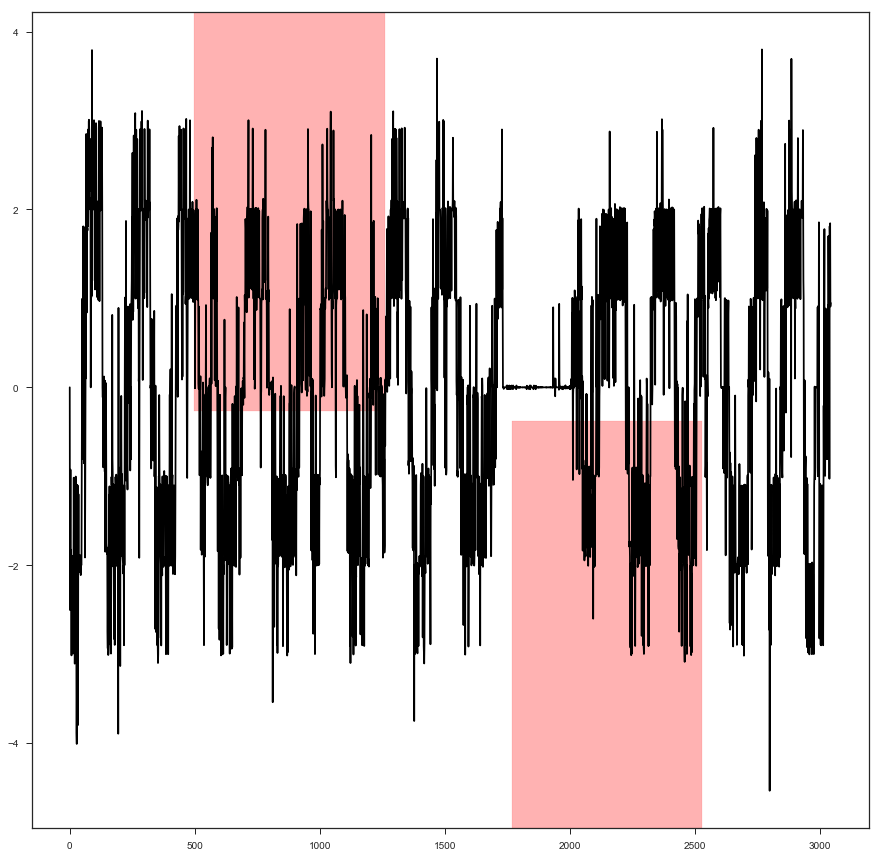

In [289]:
flyiLoc = 0
VisualizeSingleFlyTrajectory(dd, flyiLoc=flyiLoc,mark = 2473, smoothHeadX=False,speed=True)
# plt.savefig('ContactedLight_bothHalves.pdf',dpi=1000,bbox_inches='tight')
# plt.show()

In [131]:
dd['LightON index|P10'][0]

(1769, 2528)

In [213]:
def VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim):
    
    if individualFlies == None:
        meanBorder_P01 = np.mean(np.asanyarray(data['Border|P01'].tolist()),axis=0)
        meanBorder_P10 = np.mean(np.asanyarray(data['Border|P10'].tolist()),axis=0)
        meanChoiceZoneBorders_P01 = np.mean(np.asanyarray(data['ChoiceZoneBordersperFly_P01'].tolist()),axis=0)
        meanChoiceZoneBorders_P10 = np.mean(np.asanyarray(data['ChoiceZoneBordersperFly_P10'].tolist()),axis=0)
        
        #if mean == False:
        for fly in range(len(data)):
            singleFlyDf = data.iloc[fly]
            singleFlyHeadX = singleFlyDf['HeadX(pix)']

            singleFlyEntranceData_TheWindSide_P01 = singleFlyDf['FromTheWindPortEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P01 = [item[0] for item in singleFlyEntranceData_TheWindSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P01:
                axs[counter+0].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheClosedSide_P01 = singleFlyDf['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P01 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P01:
                axs[counter+numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheWindSide_P10 = singleFlyDf['FromTheWindPortEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P10 = [item[0] for item in singleFlyEntranceData_TheWindSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P10:
                axs[counter+2*numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

            singleFlyEntranceData_TheClosedSide_P10 = singleFlyDf['FromTheClosedEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P10 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P10:
                axs[counter+3*numOfGroups].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = .6, color='black')

        fontdict = {'fontsize':12}
        axs[counter+0].set_title('P01_from Wind End| %s' %(group),fontdict=fontdict)        
        axs[counter+0].axhline(meanChoiceZoneBorders_P01[0],color='grey')        
        axs[counter+0].axhline(meanChoiceZoneBorders_P01[1],color='grey')
        axs[counter+0].axhspan(meanBorder_P01,145,color='red',alpha = 0.3)
        axs[counter+0].set_ylim(ylim[0],ylim[1])

        axs[counter+numOfGroups].set_title('P01_from Closed End| %s' %(group),fontdict=fontdict)
        axs[counter+numOfGroups].axhline(meanChoiceZoneBorders_P01[0],color='grey')
        axs[counter+numOfGroups].axhline(meanChoiceZoneBorders_P01[1],color='grey') 
        axs[counter+numOfGroups].axhspan(meanBorder_P01,145,color='red',alpha = 0.3)
        axs[counter+numOfGroups].set_ylim(ylim[0],ylim[1])

        axs[counter+2*numOfGroups].set_title('P10_from Wind End| %s' %(group),fontdict=fontdict)
        axs[counter+2*numOfGroups].axhline(meanChoiceZoneBorders_P10[0],color='grey')
        axs[counter+2*numOfGroups].axhline(meanChoiceZoneBorders_P10[1],color='grey') 
        axs[counter+2*numOfGroups].axhspan(0,meanBorder_P10,color='red',alpha = 0.3)
        axs[counter+2*numOfGroups].set_ylim(ylim[0],ylim[1])

        axs[counter+3*numOfGroups].set_title('P10_from Closed End| %s' %(group),fontdict=fontdict)
        axs[counter+3*numOfGroups].axhline(meanChoiceZoneBorders_P10[0],color='grey')
        axs[counter+3*numOfGroups].axhline(meanChoiceZoneBorders_P10[1],color='grey')
        axs[counter+3*numOfGroups].axhspan(0,meanBorder_P10,color='red',alpha = 0.3)
        axs[counter+3*numOfGroups].set_ylim(ylim[0],ylim[1])
            
        #elif mean == True:
            
            
        
    elif individualFlies != None:
        
        counter = 0
        numOfflies = individualFlies[1] - individualFlies[0]
        for fly in range(individualFlies[0],individualFlies[1]):   
            
            singleFlyDf = data.iloc[fly]
            singleFlyHeadX = singleFlyDf['HeadX(pix)']
            genotype = singleFlyDf['Genotype']
            flyID = singleFlyDf['Fly ID']
            
            Border_P01 = singleFlyDf['Border|P01']
            Border_P10 = singleFlyDf['Border|P10']
            ChoiceZoneBorders_P01 = singleFlyDf['ChoiceZoneBordersperFly_P01']
            ChoiceZoneBorders_P10 = singleFlyDf['ChoiceZoneBordersperFly_P10']
        
            singleFlyEntranceData_TheWindSide_P01 = singleFlyDf['FromTheWindPortEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P01 = [item[0] for item in singleFlyEntranceData_TheWindSide_P01 if item]
            
            linewidth = 1 + 0.8*(numOfflies-1)
            for index in singleFlyEntranceIndexList_TheWindSide_P01:
                axs[counter*4+0].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheClosedSide_P01 = singleFlyDf['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P01 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P01 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P01:
                axs[counter*4+1].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheWindSide_P10 = singleFlyDf['FromTheWindPortEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheWindSide_P10 = [item[0] for item in singleFlyEntranceData_TheWindSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheWindSide_P10:
                axs[counter*4+2].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            singleFlyEntranceData_TheClosedSide_P10 = singleFlyDf['FromTheClosedEnd_P10_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX']
            singleFlyEntranceIndexList_TheClosedSide_P10 = [item[0] for item in singleFlyEntranceData_TheClosedSide_P10 if item]

            for index in singleFlyEntranceIndexList_TheClosedSide_P10:
                axs[counter*4+3].plot(range(durationAfterEntrance_frames), singleFlyHeadX[index:index+durationAfterEntrance_frames], linewidth = linewidth, color='black')

            fontdict = {'fontsize':12*(numOfGroups/1.2)}
            axs[counter*4+0].set_title('%s, ID: %s|P01_from Wind End' %(genotype,flyID),fontdict=fontdict)        
            axs[counter*4+0].axhline(ChoiceZoneBorders_P01[0],color='grey')        
            axs[counter*4+0].axhline(ChoiceZoneBorders_P01[1],color='grey')
            axs[counter*4+0].axhspan(Border_P01,145,color='red',alpha = 0.3)
            axs[counter*4+0].set_ylim(ylim[0],ylim[1])

            axs[counter*4+1].set_title('P01_from Closed End',fontdict=fontdict)
            axs[counter*4+1].axhline(ChoiceZoneBorders_P01[0],color='grey')
            axs[counter*4+1].axhline(ChoiceZoneBorders_P01[1],color='grey') 
            axs[counter*4+1].axhspan(Border_P01,145,color='red',alpha = 0.3)
            axs[counter*4+1].set_ylim(ylim[0],ylim[1])

            axs[counter*4+2].set_title('P10_from Wind End',fontdict=fontdict)
            axs[counter*4+2].axhline(ChoiceZoneBorders_P10[0],color='grey')
            axs[counter*4+2].axhline(ChoiceZoneBorders_P10[1],color='grey') 
            axs[counter*4+2].axhspan(0,Border_P10,color='red',alpha = 0.3)
            axs[counter*4+2].set_ylim(ylim[0],ylim[1])

            axs[counter*4+3].set_title('P10_from Closed End',fontdict=fontdict)
            axs[counter*4+3].axhline(ChoiceZoneBorders_P10[0],color='grey')
            axs[counter*4+3].axhline(ChoiceZoneBorders_P10[1],color='grey')
            axs[counter*4+3].axhspan(0,Border_P10,color='red',alpha = 0.3)
            axs[counter*4+3].set_ylim(ylim[0],ylim[1])
            
            counter += 1
            
    return axs

def VisualizeTheChoiceZoneTrajectories(df, individualFlies = None, groupBy = None, groupsToPlot = None, durationAfterEntrance_frames=50, 
                                       mean = False, CI = 95, hspace = .3, wspace = .3, ylim = [30,110]):
   
    if individualFlies == None:
        #if mean == False:
        if groupsToPlot == None:    
            df_grouped = df.groupby(groupBy)
            numOfGroups = len(df_grouped)
            figSize = (5*numOfGroups,20)
            fig, axs = plt.subplots(4,numOfGroups, figsize=figSize, facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = hspace, wspace = wspace)
            axs = axs.ravel()

            counter = 0

            ## for each group of flies (i.e, parent vs offspring), I'm going to plot 4 types of decision zone trajectories:
            ## P01: entrance from wind AND closed end, P10: entrance from wind AND closed end
            for group,data in df_grouped:
                axs = VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
                counter += 1

        else:    
            df_grouped = df.groupby(groupBy)
            numOfGroups = len(groupsToPlot)
            figSize = (5*numOfGroups,20)
            fig, axs = plt.subplots(4,numOfGroups, figsize=figSize, facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = hspace, wspace = wspace)
            axs = axs.ravel()  

            counter = 0
            for group in groupsToPlot:
                data = df_grouped.get_group(group)
                axs = VisualizeGroupsOfData(group,data,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
                counter += 1
        
        #elif mean == True:
            
            
    
    elif individualFlies != None:
        group = None
        counter = None
        
        numOfGroups = individualFlies[1] - individualFlies[0]
        figSize = (12*numOfGroups,4*numOfGroups**2)
        fig, axs = plt.subplots(numOfGroups,4, figsize=figSize, facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = hspace, wspace = wspace)
        axs = axs.ravel() 
        
        axs = VisualizeGroupsOfData(group,df,counter,numOfGroups,axs,individualFlies,durationAfterEntrance_frames,ylim)
        
    sns.set(style="ticks", palette="bright", color_codes=True)
    sns.despine()
    plt.show()
    return None

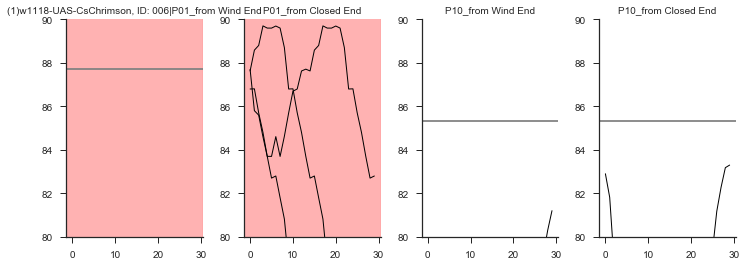

In [224]:
VisualizeTheChoiceZoneTrajectories(d, individualFlies = [5,6], groupBy = 'Genotype', groupsToPlot = None,
                                   durationAfterEntrance_frames = 30, mean=False, CI = 95, hspace = .3,
                                   wspace = .3, ylim = [80,90])

In [221]:
d['FromTheClosedEnd_P01_EnterIdx_ExitIdx_EnterHeadX_ExitHeadX'][5]

[[1045, 87.69873046875, 1058, 87.7105712890625],
 [1059, 87.627365112304688, 1060, 88.5845947265625],
 [1068, 86.796966552734375, 1099, 59.696308135986328]]

In [225]:
d['ChoiceZoneBordersperFly_P01'][5]
ChoiceZoneBorders_P01 = d['ChoiceZoneBordersperFly_P01'][5]

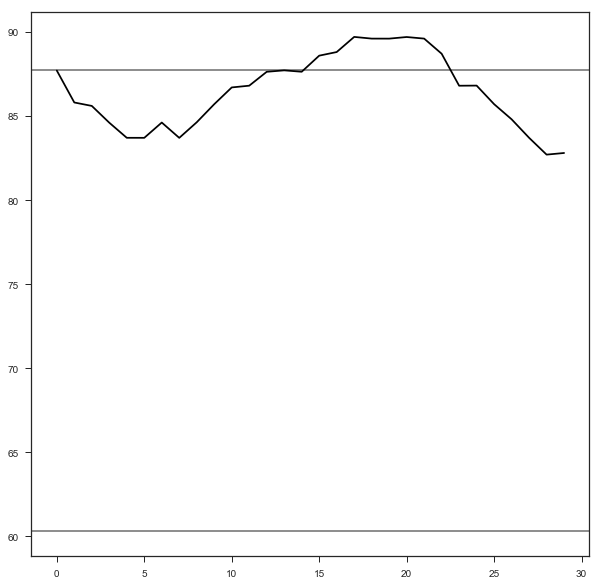

In [226]:
x = d['HeadX(pix)'][5][1045:1075]
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)
ax1.axhline(ChoiceZoneBorders_P01[0],color='grey')
ax1.axhline(ChoiceZoneBorders_P01[1],color='grey')

ax1.plot(range(len(x)), x, color='black')

## Plot any given metric

In [170]:
def plotTheMetric(df,metric,rootDir,combineControls, dropNans=False):
    
    ## open new folders to save the results
    
    newFolderName = rootDir + '/' + metric
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
        
    newFolderName = rootDir + '/' + metric + '/P01'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
        
    newFolderName = rootDir + '/' + metric + '/P10'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
    
    newFolderName = rootDir + '/' + metric + '/Mean'
    if not os.path.exists(newFolderName):
        os.makedirs(newFolderName)
    
    ## Save the df which contains the quantitative values of the given metrics, in case I need to plot them again
    savePath = rootDir + '/' + metric + '/'
    df.to_pickle(savePath + metric + '_values.pkl')
    
    ## define the color palette
    myPal = {df['Genotype'].unique()[0] : 'lightgreen',
             df['Genotype'].unique()[1] : 'cyan',
             df['Genotype'].unique()[2]:  'red'}
    
    ## get the list of vairables    
    listofSex = df['Sex'].unique()
    listofSatiety = df['Satiety'].unique()
    listofWindStat = df['Wind status'].unique()
    listofGenotypes = df['Genotype'].unique()
    
    ## if combineControls is true, then status-based df, else genotype-based.
    if combineControls == True:
        
        ## make the columns to classify data points  (status-based in this case)
        df = df.assign(Status_Sex_Satiety_LightType_Intensity_Wind = pd.Series(df['Status'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light type'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))  
        
        ## going to generate plots for each of the combination of these three condition, i.e, male_fed__NoAir
        for sex in listofSex:
            for satietyStat in listofSatiety:
                for windStat in listofWindStat:
                    
                    ## I wanted to keep the original metric name to access the columns in the df.
                    ## Generating the new variable, metricForFileName, helps me to specify whether the nans were dropped
                    ## in the file name.
                    if dropNans == False:
                        metricForFileName = metric + '_CombinedControls'
                    elif dropNans == True:
                        metricForFileName = metric + '_CombinedControls_NansDropped'
                        
                    ## P01 of the metric
                    fig,b = bs.contrastplot(df, x = 'Status_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_P01' ,
                            color_col= 'Genotype', custom_palette = myPal,  float_contrast=False,                     
                          idx = (
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_'+ str(windStat)))
                                                                  )
                    savePath = rootDir + '/' + metric + '/P01/'
                    saveFileName = metricForFileName + '_P01_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    
                    ## close the figures to save memory
                    plt.close(fig)
                    plt.clf()

                    ## P10 of the metric
                    fig,b = bs.contrastplot(df, x = 'Status_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_P10' ,
                            color_col= 'Genotype', custom_palette = myPal,  float_contrast=False,                     
                          idx = (
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_'+ str(windStat)))
                                                                  )
                    savePath = rootDir + '/' + metric + '/P10/'
                    saveFileName = metricForFileName + '_P10_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    plt.close(fig)
                    plt.clf()

                    ## Mean of the metric
                    fig,b = bs.contrastplot(df, x = 'Status_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_Mean' ,
                            color_col= 'Genotype', custom_palette = myPal, float_contrast=False,                     
                          idx = (
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                 ('Parent_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 'Offspring_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_'+ str(windStat)))
                                                                  )
                    savePath = rootDir + '/' + metric + '/Mean/'
                    saveFileName = metricForFileName + '_Mean_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    plt.close(fig)
                    plt.clf()
    
    elif combineControls == False:  
        ## generate the columns to callsify the data points, this time genotype-based
        df = df.assign(Genotype_Sex_Satiety_LightType_Intensity_Wind = pd.Series(df['Genotype'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light type'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))
        
        ## going to generate plots for each of the combination of these three condition, i.e, male_fed__NoAir
        for sex in listofSex:
            for satietyStat in listofSatiety:
                for windStat in listofWindStat:
                    
                    ## I wanted to keep the original metric name to access the columns in the df.
                    ## Generating the new variable, metricForFileName, helps me to specify whether the nans were dropped
                    ## in the file name.
                    if dropNans == False:
                        metricForFileName = metric
                    elif dropNans == True:
                        metricForFileName = metric + '_NansDropped'
                        
                    ## P01 of the metric
                    fig,b = bs.contrastplot(df, x = 'Genotype_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_P01' ,
                            color_col= 'Genotype', custom_palette = myPal,                      
                          idx = (
                                 (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                              
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                  
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat))))
                        
                    savePath = rootDir + '/' + metric + '/P01/'
                    saveFileName = metricForFileName + '_P01_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    
                    ## close the figures to save memory
                    plt.close(fig)
                    plt.clf()

                    
                    ## P10 of the metric
                    fig,b = bs.contrastplot(df, x = 'Genotype_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_P10' ,
                            color_col= 'Genotype', custom_palette = myPal,                      
                          idx = (
                                 (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                              
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                  
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat))))
                        
                    savePath = rootDir + '/' + metric + '/P10/'
                    saveFileName = metricForFileName + '_P10_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    
                    ## close the figures to save memory
                    plt.close(fig)
                    plt.clf()
                    
                    ## Mean of the metric
                    fig,b = bs.contrastplot(df, x = 'Genotype_Sex_Satiety_LightType_Intensity_Wind', y = metric+'_Mean' ,
                            color_col= 'Genotype', custom_palette = myPal,                      
                          idx = (
                                 (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_14uW_' + str(windStat)),
                              
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_42uW_' + str(windStat)),
                                  
                                  (str(listofGenotypes[0]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat), 
                                  str(listofGenotypes[1]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat),
                                  str(listofGenotypes[2]) + '_' + str(sex) + '_' + str(satietyStat) + '_Constant_70uW_' + str(windStat))))
                        
                    savePath = rootDir + '/' + metric + '/Mean/'
                    saveFileName = metricForFileName + '_Mean_' + str(sex) + '_' + str(satietyStat) + '_' + str(windStat)
                    plt.savefig(savePath + saveFileName + '.pdf',dpi=1000,bbox_inches='tight')
                    b.to_csv(savePath + saveFileName + '.csv')
                    
                    ## close the figures to save memory
                    plt.close(fig)
                    plt.clf()
    
    return None



## Execute

In [2]:
import os
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy as sp
import numpy as np
import datetime as dt
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from itertools import groupby
from operator import itemgetter
import bootstrap_contrast as bs
from nptdms import *
import math
from collections import Counter
import shutil
import progressbar

# rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure'
# d, t = WALiMe(rootDir=rootDir, metrics = ['TSALE'])

C:\Users\tumkayat\AppData\Local\Continuum\Anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
df = pd.read_pickle('C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a/RawDataFrame.pkl')

In [4]:
# df = df.copy(deep=True)
df['Light Intensity(uW/mm2)'] = df['Light Intensity(uW/mm2)'].str[3:-9]

In [5]:
df = df.assign(Status_Sex_Satiety_LightType_Intensity_Wind = pd.Series(df['Status'] + '_' + df['Sex'] + '_' +
             df['Satiety'] + '_' + df['Light type'] + '_' + df['Light Intensity(uW/mm2)'] + '_' +
             df['Wind status'], index = df.index))  

In [171]:
# TSALE(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', dropNans=False, combineControls=True)
# LaXS(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', combineControls=False)
# weighted_TSALE(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', dropNans=True, combineControls=True)
# LAI(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', dropNans=False, combineControls=True)
# RPI(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', dropNans=False, combineControls=True)
NoBC(df, rootDir = 'C:/Users/tumkayat/Desktop/CodeRep/WALiSAR/BehaviroalDataAnalyses/WALiSuite_v0.1/SampleFolderStructure/Or9a', dropNans=False, combineControls=True)

,Tdms file name,Date,Time,mmPerPix,fps,Light type,Light Intensity(uW/mm2),Wind status,Satiety,Genotype,...,LightON index|P01,First light contact index in P01,First light contact index in P10,LightON index|P10,Border|P01,Border|P10,Status_Sex_Satiety_LightType_Intensity_Wind,NoBC_P01,NoBC_P10,NoBC_Mean
0,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",0.0,0.0,"(1769, 2528)",74.15,72.33,Parent_male_Satiated_Constant_14uW_NoAir,5,8,6.5
1,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",43.0,0.0,"(1769, 2528)",74.11,72.18,Parent_male_Satiated_Constant_14uW_NoAir,8,5,6.5
2,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",406.0,88.0,"(1769, 2528)",74.07,72.05,Parent_male_Satiated_Constant_14uW_NoAir,2,5,3.5
3,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",355.0,336.0,"(1769, 2528)",74.07,71.82,Parent_male_Satiated_Constant_14uW_NoAir,6,1,3.5
4,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",0.0,0.0,"(1769, 2528)",74.10,71.81,Parent_male_Satiated_Constant_14uW_NoAir,7,1,4.0
5,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",249.0,0.0,"(1769, 2528)",74.01,71.64,Parent_male_Satiated_Constant_14uW_NoAir,2,3,2.5
6,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",0.0,292.0,"(1769, 2528)",73.87,71.49,Parent_male_Satiated_Constant_14uW_NoAir,6,5,5.5
7,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",0.0,0.0,"(1769, 2528)",73.87,71.36,Parent_male_Satiated_Constant_14uW_NoAir,8,8,8.0
8,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",128.0,0.0,"(1769, 2528)",73.93,71.25,Parent_male_Satiated_Constant_14uW_NoAir,6,5,5.5
9,LOG_2017-02-01_11-16-46_(1)w1118-UAS-CsChrimso...,2017-02-01,11-16-46,0.365,16,Constant,14uW,NoAir,Satiated,(1)w1118-UAS-CsChrimson,...,"(499, 1260)",45.0,NaN,"(1769, 2528)",73.68,71.12,Parent_male_Satiated_Constant_14uW_NoAir,5,0,2.5
